In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import math
from astropy import constants as const

In [2]:
# initialize number of slices for planet's surface 

num_slices = 16 # num_slices needs to be multiple of 4 - why does it need to be multiples of 4?

# intialize arrays for thermal flux

f_thermal = np.zeros((num_slices,))

# initialize arrays for reflected flux

f_reflection = np.zeros((num_slices,))

In [3]:
# calculate thermal flux

def calc_thermal_flux(num_slices = num_slices, f_drop = 1.0, shift = 0.1, interp_power=1.0):
    # shift in phase from 0 to 2pi
    
    # f_thermal is the flux for each slice
    f_thermal = np.zeros((num_slices,))
    
#     print(f_thermal, 'f thermal')
    
    f_thermal_sum = np.zeros((num_slices,))
    f_thermal[0] = 1.0
    
    # divide by two to show where the nightside begins
    night_ind = int((num_slices) / 2)
    
    # not sure why dividing half visible by 4?
    half_visible = int((num_slices) / 4)
    
    ind = np.arange(0,night_ind)
#     print(ind, 'ind')
    
    # mapping out the temperature drop at each slice
    f_thermal[ind] = 1.0 - f_drop * (ind / night_ind)**interp_power
    
#     print(f_thermal[ind], 'f_thermal[ind]')
    
    # assigning nightside temperatures
    f_thermal[night_ind] = 1.0 - f_drop
#     print(f_thermal[night_ind], 'f_thermal[night_ind]')
    
    # assigning dayside temperatures
    f_thermal[-1:night_ind:-1] = f_thermal[1:night_ind]
#     print(f_thermal[-1:night_ind:-1], 'f_thermal[-1:night_ind:-1]')

    
    # now sum up visible sphere
    
    for i in np.arange(num_slices):
        f_thermal_new = np.roll(f_thermal, i)
#         print(f_thermal_new, 'f_thermal_new')
        f_thermal_sum[i] = np.sum(f_thermal_new[night_ind-half_visible:night_ind+half_visible+1])
        
    
    # why add the 1e9 ?
    phase_arr = np.arange(0, 2*np.pi, 2*np.pi / num_slices)
    
    return((phase_arr + shift) % (2 * np.pi), f_thermal_sum)
    
    

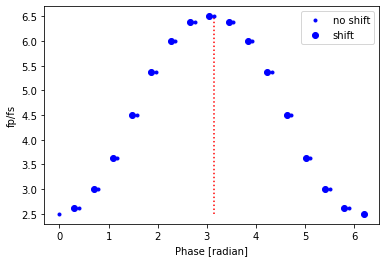

In [4]:
phase_arr, f_thermal_sum = calc_thermal_flux(shift = 0.0)

# print(f_thermal_sum, 'f_thermal_sum')

# print(np.max(f_thermal_sum) - np.min(f_thermal_sum))
# for i in np.arange(num_slices):
#     print(phase_arr[i], f_thermal_sum[i])

plt.plot(phase_arr, f_thermal_sum, color="blue", linestyle="None", marker=".", label = 'no shift')
plt.vlines(np.pi, np.min(f_thermal_sum), np.max(f_thermal_sum), linestyle="dotted", color="red")

phase_arr, f_thermal_sum = calc_thermal_flux(shift = -0.09)
plt.plot(phase_arr, f_thermal_sum, color="blue", linestyle="None", marker="o", label = 'shift')
plt.xlabel("Phase [radian]")
plt.ylabel("fp/fs")
plt.legend()


2.0 0.5
4.0 1
6.0 1.5
8.0 2


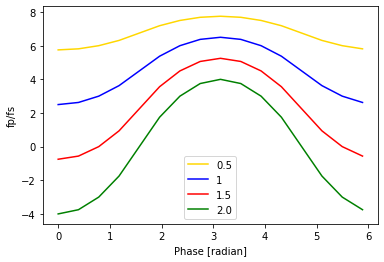

In [5]:
phase_arr_5, f_thermal_sum_5 = calc_thermal_flux(shift = 0.0, f_drop = 0.5)

phase_arr_1, f_thermal_sum_1 = calc_thermal_flux(shift = 0.0, f_drop = 1.0)

phase_arr_2, f_thermal_sum_2 = calc_thermal_flux(shift = 0.0, f_drop = 1.5)

phase_arr_3, f_thermal_sum_3 = calc_thermal_flux(shift = 0.0, f_drop = 2.0)

print(np.max(f_thermal_sum_5) - np.min(f_thermal_sum_5), '0.5')
print(np.max(f_thermal_sum_1) - np.min(f_thermal_sum_1), '1')
print(np.max(f_thermal_sum_2) - np.min(f_thermal_sum_2), '1.5')
print(np.max(f_thermal_sum_3) - np.min(f_thermal_sum_3), '2')

plt.plot(phase_arr_5, f_thermal_sum_5, color="gold", label = '0.5')
plt.plot(phase_arr_1, f_thermal_sum_1, color="blue", label = '1')
plt.plot(phase_arr_2, f_thermal_sum_2, color="red", label = '1.5')
plt.plot(phase_arr_3, f_thermal_sum_3, color="green", label = '2.0')
plt.xlabel("Phase [radian]")
plt.ylabel("fp/fs")
plt.legend()

In [6]:
# blackbody function

def blackbody_function(wavelength, T):
    h = 6.62607015e-27 * (u.erg * u.s)
    c = (3*10**8) * (u.m/u.s)
    k = (1.38*10**-16) * (u.erg/u.K)
    T = T.to(u.K)
    wavelength = wavelength.to(u.m)
    nu = (c / wavelength)
    B_T = ((2*h*nu**3)/(c**2)) * (1 / (np.exp((h*nu) / (k*T)) - 1)) / u.rad**2
    return B_T.to(u.erg / u.s / u.cm**2 / u.Hz / u.rad**2)

In [7]:
# blackbody function (white light curve)

# find number of photons over entire wavelength range

wavelength_range = np.arange(600, 1000, 1)

wavelength_range = wavelength_range * u.nm


In [8]:
# telescope parameters

def telescope_scaling(exp_time, aperature, central_wavelength, resolving_power):
    exp_time = exp_time.to(u.s)
    aperature = np.pi * ((aperature.to(u.cm) / 2) **2)
    spec_res = central_wavelength.to(u.micron) / resolving_power
    scaling_factor = aperature * exp_time * spec_res
    return scaling_factor

In [9]:
# convert fnu to flam

def steradian_calc(rad_planet, obs_dis, wavelength, T):
    fnu = blackbody_function(wavelength, T)
    rad_planet = rad_planet.to(u.cm)
    obs_dis = obs_dis.to(u.cm)
    theta = np.arctan((rad_planet / obs_dis).value) * u.radian
    angle_area = np.pi * theta**2
    fnu = (fnu * angle_area)
    flam = fnu.to(u.erg / u.s / u.cm**2 / u.micron, u.spectral_density(wavelength))
    return flam

In [10]:
# calculate thermal emission

def emission(exp_time, aperature, central_wavelength, resolving_power, temp, rad, obs_dis, wavelength):
    # multiply by expsoure time, aperature and spectral resolution to get photons
    
    scaling_factor = telescope_scaling(exp_time, aperature, central_wavelength, resolving_power)
    
    
    # plot blackbody function for planet multiplied by scaling factor for telescope
    
    
    flam = steradian_calc(rad, obs_dis, wavelength, temp)
    
    flux_emission = flam * scaling_factor #* planet_scaling1
    return flux_emission

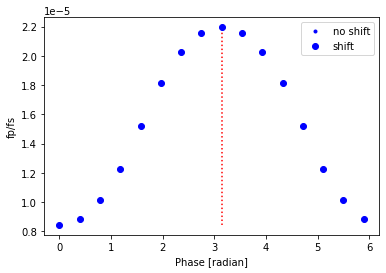

In [13]:
# if planet day-side flux is 1, then stellar flux is 
# B_star / B_day_side * (R_star / R_planet)**2 * (num_slices -1), 
# where B_star / B_day_side is the blackbody radiation at a particular wavelength
# assume B_star / B_day_side = 10, R_star / R_planet = 10

# ratio of blackbody radiation from star to planet

temp_star = 7650
temp_planet = 2786

B_star = blackbody_function(wavelength = 786.5 * u.nm, T = temp_star * u.K)

B_dayside = blackbody_function(wavelength = 786.5 * u.nm, T = temp_planet * u.K)

B_ratio = B_star / B_dayside

# print(B_ratio)

# ratio of radius from star to planet

# R_planet = 1.240 * u.jupiterRad

R_star = 2.494 * u.R_sun

R_planet = (1.512 * u.jupiterRad)

R_ratio = (R_star.to(u.m) / R_planet.to(u.m))

# B is proportional to R**2, why multiplied by num_slices?
f_star = (B_ratio * (R_ratio)**2 * (num_slices))


flux_star = emission(exp_time = 8 * u.min, aperature = 10 * u.cm, central_wavelength = 786.5 * u.nm, resolving_power = 60, temp = temp_star * u.K, rad = R_star, obs_dis = 519 * u.parsec, wavelength = wavelength_range)
# print(len(flux_star))

# print(flux_star)

integrated_flux_star = sum(flux_star)

# print(integrated_flux_star)
# print(flux_star)

# print(f_star)

phase_arr, f_thermal_sum = calc_thermal_flux(shift = 0.0)
# for i in np.arange(num_slices):
#     print(phase_arr[i], f_thermal_sum[i])

# plot in terms of F_p / F_star
plt.plot(phase_arr, f_thermal_sum / f_star, color="blue", linestyle="None", marker=".", label = 'no shift')
plt.vlines(np.pi, np.min(f_thermal_sum / f_star), np.max(f_thermal_sum / f_star), linestyle="dotted", color="red")

phase_arr, f_thermal_sum = calc_thermal_flux(shift = 0)
plt.plot(phase_arr, f_thermal_sum / f_star, color="blue", linestyle="None", marker="o", label = 'shift')
plt.xlabel("Phase [radian]")
plt.ylabel("fp/fs")
plt.legend()

In [14]:
# temp_star = 5616
# temp_planet = 2050

# B_star = blackbody_function(wavelength = 786.5 * u.nm, T = temp_star * u.K)

# B_dayside = blackbody_function(wavelength = 786.5 * u.nm, T = temp_planet * u.K)

# B_ratio = B_star / B_dayside

# print(B_ratio)

# # 71, 120



# R_star = 2.2 * u.R_sun

# R_planet = (1.521 * u.jupiterRad)

# R_ratio = (R_star.to(u.m) / R_planet.to(u.m))

# print(R_ratio)

In [17]:
# add noise

number_of_photons = flux_star / ((6.62607015e-27 * (u.erg * u.s)) * ((3*10**8) * (u.m/u.s)) / ((wavelength_range).to(u.m)))
star_photons = np.random.poisson(number_of_photons)
print(len(star_photons))
photon_err = np.sqrt(sum(star_photons))

# photon_err_erg = np.sqrt(star_photons) * ((6.62607015e-27 * (u.erg * u.s)) * ((3*10**8) * (u.m/u.s)) / ((1 * u.micron).to(u.m))) # error bars in erg


print(sum(star_photons))
# print(photon_err)
# star_photons = new_star_photons * ((6.62607015e-27 * (u.erg * u.s)) * ((3*10**8) * (u.m/u.s)) / ((1 * u.micron).to(u.m)))

# print(star_photons)

# print((photon_err / star_photons))

# phase_arr = np.arange(0, 2*np.pi, 2*np.pi / num_slices)

# print(len(phase_arr))

400
113505506
16


[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120.]


<ipython-input-32-4e2455bfff67>:9: RuntimeWarning: divide by zero encountered in double_scalars
  photon_noise = (1 / np.sqrt(sum(star_photons))) * 10**6


Text(0.5, 0, 'exposure time [s]')

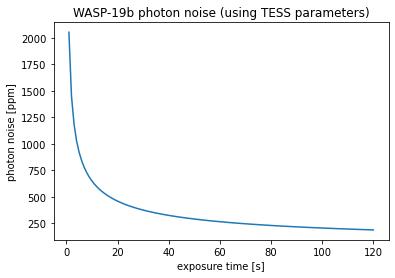

In [32]:
x = np.linspace(0, 120, 121)
print(x)
y = []

for i, value in enumerate(x):
    flux_star = emission(exp_time = value * u.s, aperature = 10 * u.cm, central_wavelength = 786.5 * u.nm, resolving_power = 60, temp = temp_star * u.K, rad = R_star, obs_dis = 519 * u.parsec, wavelength = wavelength_range)
    number_of_photons = flux_star / ((6.62607015e-27 * (u.erg * u.s)) * ((3*10**8) * (u.m/u.s)) / ((wavelength_range).to(u.m)))
    star_photons = np.random.poisson(number_of_photons)
    photon_noise = (1 / np.sqrt(sum(star_photons))) * 10**6
    y.append(photon_noise)


plt.plot(x, y)
plt.title('WASP-19b photon noise (using TESS parameters)')
plt.ylabel('photon noise [ppm]')
plt.xlabel('exposure time [s]')

In [18]:
def calc_reflection_flux(num_slices = num_slices, albedo = 200e-6, shift = np.pi):
    # shift in phase from 0 to 2pi
    
    # initialize the reflection flux array
    f_reflection = np.zeros((num_slices,))
    
    # initialize the phase array
    phase_arr = np.arange(0, 2*np.pi + 1e-9, 2*np.pi / num_slices)
    
    # nightside indices
    night_ind = int((num_slices) / 2)
    
    # phase only goes between 0 and pi because reflectance equation only takes in phases from 0 to pi?
    
    # only use 
    phase_tmp = phase_arr[0:night_ind+1] #+ np.pi
#     print(phase_tmp, 'phase_tmp')
    
    
    # lambertian reflectance formula
    f_reflection[0:night_ind+1] = (np.sin(phase_tmp) + \
                                   (np.pi - phase_tmp) * \
                                   np.cos(phase_tmp)) / np.pi
    
    
#     print(f_reflection[0:night_ind+1], '[0:night_ind+1]')
    
    # not sure what this does?
#     print(f_reflection[-1:night_ind:-1], 'f_reflection[-1:night_ind:-1]')
#     print(f_reflection[1:night_ind], 'f_reflection[1:night_ind]')
    f_reflection[-1:night_ind:-1] = f_reflection[1:night_ind]
    
    # just albedo scaling multiplied by f_reflection?
    
    return((phase_arr[0:num_slices] + shift) % (2 * np.pi), albedo * f_reflection)

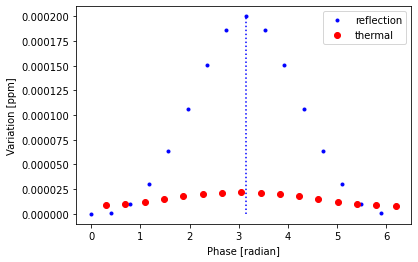

In [19]:
phase_arr_reflection, f_reflection = calc_reflection_flux(shift = np.pi)
phase_arr_thermal, f_thermal_sum = calc_thermal_flux(shift = -0.09)

plt.plot(phase_arr_reflection, f_reflection, color="blue", linestyle="None", label="reflection", marker='.')

plt.vlines(np.pi, np.min(f_reflection), np.max(f_reflection), linestyle="dotted", color="blue")

plt.plot(phase_arr_thermal, f_thermal_sum / f_star, color="red", linestyle="None", label="thermal", marker="o")
plt.xlabel("Phase [radian]")
plt.ylabel("Variation [ppm]")
plt.legend()

63


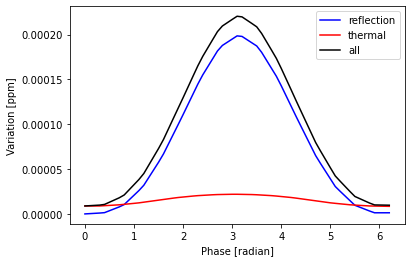

In [20]:

phase_resamp = np.arange(0, 2*np.pi, 0.1)
print(len(phase_resamp))
ind = np.argsort(phase_arr_reflection)

# interpolate between the resampled phase and the reflection phase array
f_reflection_resamp = np.interp(phase_resamp, phase_arr_reflection[ind], f_reflection[ind])

f_thermal_tmp = f_thermal_sum / f_star
ind = np.argsort(phase_arr_thermal)

# interpolate between the resampled phase and the thermal phase array
f_thermal_resamp = np.interp(phase_resamp, phase_arr_thermal[ind], f_thermal_tmp[ind])

plt.plot(phase_resamp, f_reflection_resamp, color="blue", label="reflection")
plt.plot(phase_resamp, f_thermal_resamp, color="red", label="thermal")
plt.plot(phase_resamp, f_reflection_resamp + f_thermal_resamp, color="black", label="all")
plt.xlabel("Phase [radian]")
plt.ylabel("Variation [ppm]")
plt.legend()



In [93]:
# total flux

def calc_model(theta, x, num_slices=num_slices):
    
    # parameters for model calculation
    albedo, shift_reflection, f_drop, shift_thermal, interp_power, B_sp, R_sp = theta
    
    # thermal flux
    phase_arr_thermal, f_thermal_sum = calc_thermal_flux(num_slices = num_slices, f_drop = f_drop, \
                                                     shift = shift_thermal, interp_power=interp_power)
    
    # reflective flux
    phase_arr_reflection, f_reflection = calc_reflection_flux(num_slices = num_slices, albedo = albedo, \
                                                              shift = shift_reflection)
    
    # flux of star
    f_star = B_sp * R_sp**2 * (num_slices)
    
    # ratio of planet to star flux (use thermal like in previous model)
    f_thermal_tmp = f_thermal_sum / f_star
    ind = np.argsort(phase_arr_thermal)
    f_thermal_resamp = np.interp(x, phase_arr_thermal[ind], f_thermal_tmp[ind])
    
    ind = np.argsort(phase_arr_reflection)
    f_reflection_resamp = np.interp(x, phase_arr_reflection[ind], f_reflection[ind])

    return(f_thermal_resamp + f_reflection_resamp)


In [94]:
albedo, shift_reflection, f_drop, shift_thermal, interp_power, B_sp, R_sp \
            = 200e-6, np.pi, 1.0, np.pi, 0, B_ratio, R_ratio

theta_true = albedo, shift_reflection, f_drop, shift_thermal, interp_power, B_sp, R_sp

f_model = calc_model(theta_true, phase_resamp)

yerr_scale = photon_err / sum(star_photons)

noise_level = 1 / np.sqrt(sum(star_photons))

# print(noise_level)

x = phase_resamp

# center of the Gaussian distribution, width of the distribution (standard deviation), output shape

# generated data in a Gaussian distribution
y = np.random.normal(loc=f_model, scale=noise_level, size=np.shape(f_model))
yerr = np.zeros(np.shape(y)) + yerr_scale
# print(yerr)
print(B_sp)
print(noise_level * 10**6)



71.81168463501912
93.86189213797904


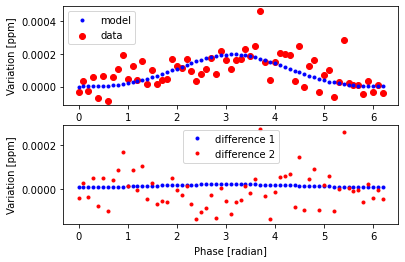

In [95]:
plt.subplot(211)
plt.plot(phase_resamp, f_model, label="model", linestyle="none", color="blue", marker=".")
# plt.plot(phase_resamp, f_data, color="red", label="all", linestyle="solid")
plt.scatter(x, y, color="red", label="data", linestyle="solid")

plt.xlabel("Phase [radian]")
plt.ylabel("Variation [ppm]")
# plt.ylim(0.05, 0.06)
plt.legend()

plt.subplot(212)
plt.plot(phase_resamp, f_reflection_resamp + f_thermal_resamp - f_model, label="difference 1", \
         linestyle="none", color="blue", marker=".")
plt.plot(phase_resamp, y - (f_reflection_resamp + f_thermal_resamp), label="difference 2", \
         linestyle="none", color="red", marker=".")
plt.xlabel("Phase [radian]")
plt.ylabel("Variation [ppm]")
plt.legend()


# print(y - (f_reflection_resamp + f_thermal_resamp))

Some results from my photon noise calculation:

WASP-19b: literature (0.0008 to 0.001), my values (0.0003)
KELT-9b: literature (40 to 50 ppm), my values (58 ppm)
KELT-12b: literature (~0.0001), my values (0.00018)

In [191]:
y_ppm = y * 10**6

print(np.max(y_ppm) - np.min(y_ppm))

f_ppm = (y - (f_reflection_resamp + f_thermal_resamp)) * 10**6

print(np.max(f_ppm) - np.min(f_ppm))

print(np.max(f_ppm))

# print(f_data)

print(B_sp)

158695.51144568605
158395.65239540272
158190.53306130963
50.40942824301827


In [109]:
def log_likelihood(theta, x, y, yerr):
    albedo, shift_reflection, f_drop, shift_thermal, interp_power, B_sp, R_sp = theta
    model = calc_model(theta, x, num_slices=num_slices)
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [110]:
def log_prior(theta):
    albedo, shift_reflection, f_drop, shift_thermal, interp_power, B_sp, R_sp = theta
    if 0.0 < albedo < 1e-3 and -np.pi < shift_reflection < (2 * np.pi) \
        and 0.0 < f_drop <= 1.5 and -np.pi < shift_thermal < np.pi \
        and 0.5 < interp_power < 2.0 and 1.0 < B_sp < 100.0 and 5.0 < R_sp < 20.0:
        return 0.0
    return -np.inf

In [111]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [145]:
def logPrior(theta):
    ''' Calculates gaussian/uniform priors for MCMC fitting.
        
        Parameters
        ----------
        theta : 1-D numpy array
            Model parameters
        priors : 2-D numpy array 
            Pairs of values representing prior ranges for each model parameter
        priors_bool : 1-D boolean array
            True if uniform prior, False if Gaussian prior
        
        Returns
        -------
        prior_norm : float 
            Prior probability
    '''
    albedo, shift_reflection, f_drop, shift_thermal, interp_power, B_sp, R_sp = theta
    priors = np.array([[0.0, 1e-3], [-np.pi, 2 * np.pi], [0.0, 1.5], [-np.pi, np.pi], [0.5, 2.0], [1.0, 10.0], [11.0, 1.0]])
    priors_bool = np.array([True, True, True, True, True, True, False])
    
    priors_uniform = priors[priors_bool]
    theta_uniform = theta[priors_bool]
    prior_norm = 0
    # Uniform priors
    for i, prior in enumerate(priors_uniform):
        lower, upper = prior
        if not (lower < theta_uniform[i] < upper):
            prior_norm += -np.inf
        else:
            prior_norm += np.log(1./(upper-lower))
    # Gaussian priors
    priors_gauss = priors[~priors_bool]
    priors_gauss_center, priors_gauss_width = priors_gauss[:,0], priors_gauss[:,1]
    theta_gauss = theta[~priors_bool]
    coef = np.sum(-np.log(priors_gauss_width*np.sqrt(2.*np.pi)))
    chi2 = np.sum(((theta_gauss-priors_gauss_center)/priors_gauss_width)**2.)
    exponent = -chi2/2.
    prior_norm += coef + exponent
    return prior_norm#/len(theta)

In [146]:
def log_probability_new(theta, x, y, yerr):
    lp = logPrior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4 5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2]
[ 6.10538015e-05 -6.54914436e-05 -1.62075102e-05  1.07689853e-04
  5.11945509e-05  8.96472161e-05 -4.56320139e-05 -8.82213186e-06
 -9.71660958e-05 -4.34075213e-05  1.45399924e-05 -1.58941452e-05
 -6.57274536e-05  2.59036816e-05  3.42197812e-05  4.31757271e-06
  2.16506282e-05  5.73030343e-05  4.84241750e-05  6.83904789e-05
  8.83187528e-05  1.12143790e-04  8.55560243e-05  2.06611995e-04
  1.59992506e-04  1.89590591e-04  1.36840690e-04  2.02494081e-04
  2.59153676e-04  1.59512404e-04  2.35563343e-04  1.52337453e-04
  1.68166146e-04  1.75085531e-04  3.06426600e-04  1.66207125e-04
  1.59501518e-04  1.73800908e-04  2.44110558e-04  2.31462494e-04
  2.33148455e-04  1.94997995e-05  1.81224074e-04  1.27053020e-04
  1.43340263e-04  1.28216367

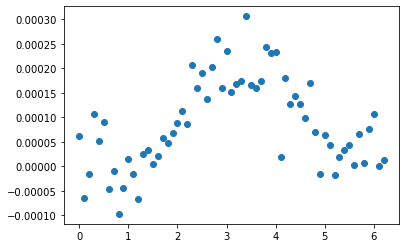

In [147]:
print(x)
print(y)

plt.scatter(x, y)
# plt.errorbar(x, y, yerr=yerr)
plt.show()

In [148]:
import emcee

ndim = len(theta_true)
pos = theta_true + 1e-6 * np.random.randn(32, ndim)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_new, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 10000, progress=True);

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/sharongary/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [00:14<00:00, 707.21it/s]


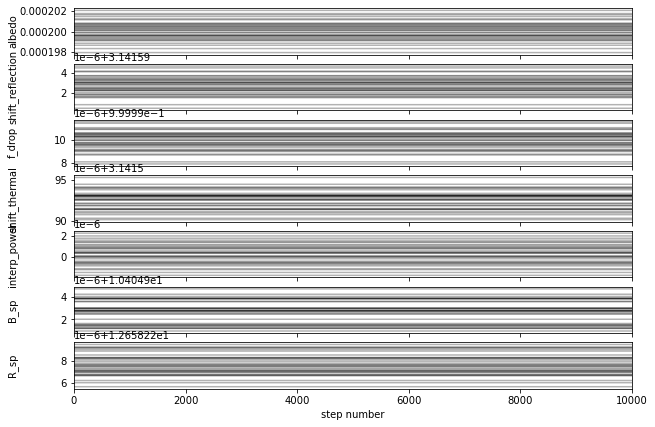

In [149]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["albedo", "shift_reflection", "f_drop", "shift_thermal", "interp_power", "B_sp", "R_sp"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [150]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)


(19200, 7)


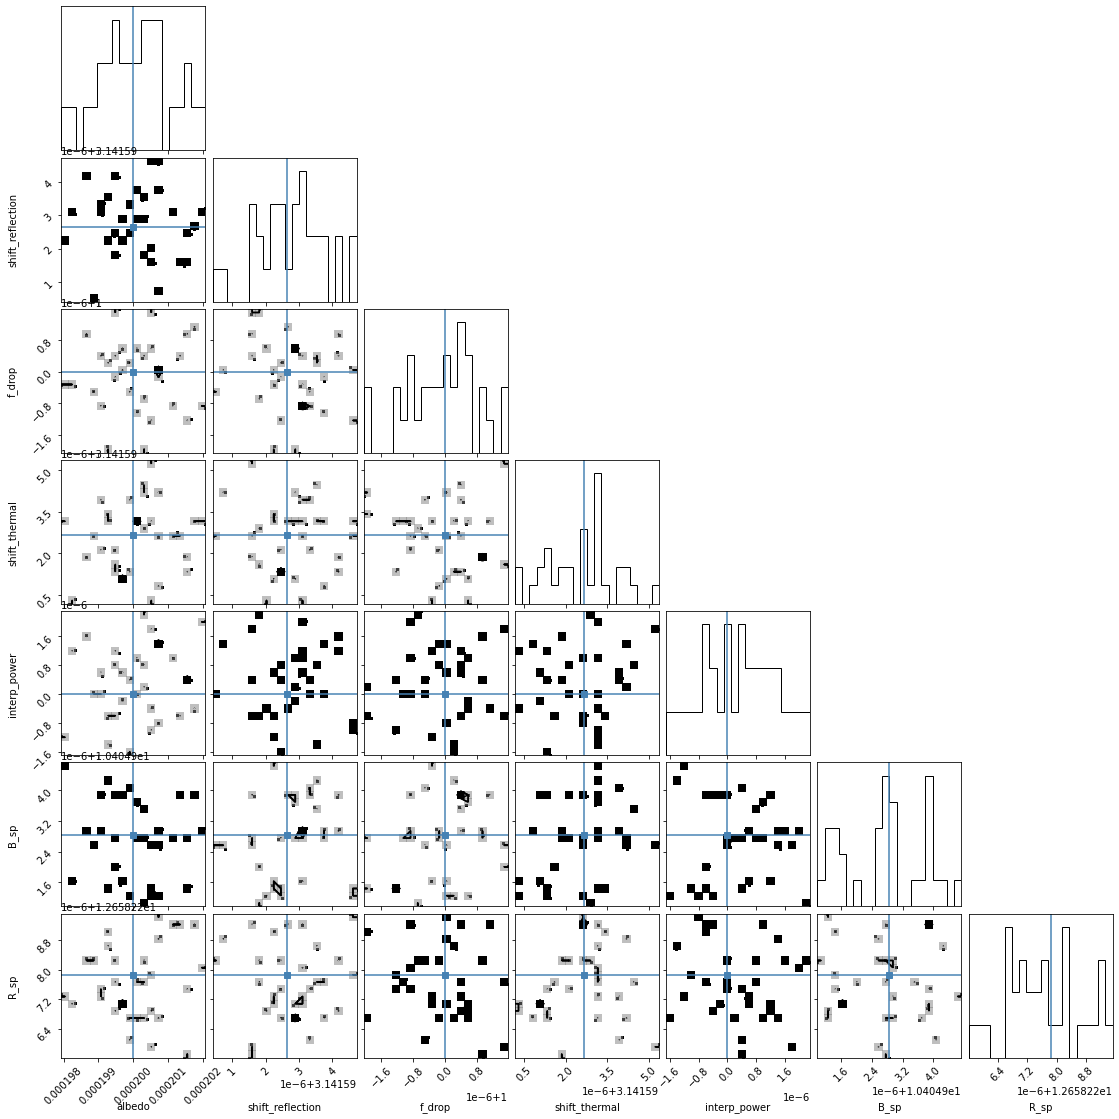

In [151]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=theta_true
);

In [152]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [153]:
mcmc = []
for i in range(ndim):
    mcmc_i = np.percentile(flat_samples[:, i], [16, 50, 84])
    mcmc.append(mcmc_i)
mcmc = np.array(mcmc)

theta_bestfit = (mcmc[0][1], mcmc[1][1], mcmc[2][1], mcmc[3][1], mcmc[4][1], mcmc[5][1], mcmc[6][1])
print(theta_bestfit)

(0.00020011283000562525, 3.141592812814426, 0.999999984173882, 3.141592690780977, 4.0899959938660717e-07, 10.404902783239539, 12.658227546200814)


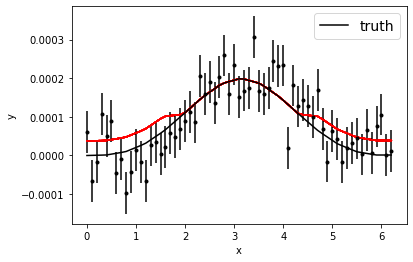

In [154]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    model_trial = calc_model(theta_bestfit, x)
    plt.plot(x, model_trial, "C1", alpha=0.1, color = 'red')
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, calc_model(theta_true, x), "k", label="truth")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");

In [20]:
L_j = (1500 * (u.m / u.s) / ((const.G) * (985 * (u.kg / u.m**3))) ** (1/2)).to(u.R_earth)

print(L_j)

0.9172314932518624 earthRad
